In [1]:
!nvidia-smi

Thu Nov 14 03:58:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import zipfile
import os
zip_file_path = '/content/archive (11).zip'

# Extract the zip file
extracted_folder = '/content/fer2013_dataset'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)


os.listdir(extracted_folder)

['test', 'train']

In [3]:
!pip install fastai
!pip install torch

In [5]:
from fastai.vision.all import *

# Define the custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Creating classes
model = CustomCNN(num_classes)

In [6]:
# Define the paths
train_path = '/content/fer2013_dataset/train'
valid_path = '/content/fer2013_dataset/test'

# List the categories (emotions) in the dataset
emotion_classes = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

# DataBlock setup
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image and category
    get_items=get_image_files,  # Get image files
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),  # Split data by folders
    get_y=parent_label,  # Labels are the parent folder names
    item_tfms=Resize(128),  # Resize images to 128x128
    batch_tfms=aug_transforms()  # Augmentations
)

# Load the data
dls = dblock.dataloaders(extracted_folder, bs=64)

In [7]:
# Create the learner object with the custom model
learn = Learner(dls, model, metrics=accuracy)

# Train the model
learn.fine_tune(30)

epoch,train_loss,valid_loss,accuracy,time
0,1.692482,1.611652,0.366955,01:23


epoch,train_loss,valid_loss,accuracy,time
0,1.560568,1.473952,0.434940,01:23
1,1.494309,1.426062,0.452912,01:21
2,1.448960,1.373699,0.463221,01:20
3,1.417337,1.335704,0.487462,01:24
4,1.380091,1.289409,0.502090,01:23
5,1.343031,1.277566,0.506130,01:22
6,1.304655,1.253940,0.512399,01:21
7,1.254967,1.208364,0.533296,01:24
8,1.239542,1.191691,0.540123,01:23
9,1.208111,1.165725,0.550571,01:21


In [8]:
# Save the trained model
learn.save('emotion_model')
learn.export('emotion_model.pkl')
# Evaluate the model on the validation set
val_loss, val_acc = learn.validate()

# Print the validation accuracy and loss
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.4f}")

Validation Accuracy: 0.61
Validation Loss: 1.0579


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from fastai.vision.all import *
import pandas as pd
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
# Path to the dataset
path = "/content/fer2013_dataset"

# DataBlock setup with stronger data augmentation
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=[
        *aug_transforms(size=128, max_rotate=10, max_zoom=1.1, max_lighting=0.3, max_warp=0.2),
        Normalize.from_stats(*imagenet_stats)
    ]
)

# DataLoaders
dls = dblock.dataloaders(path, bs=32)

In [15]:
# Initialize the custom model with the correct number of classes
num_classes = 7
model = CustomCNN(num_classes)

# Create the learner object with the custom model
learn = Learner(dls, model, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,1.763878,1.801940,0.243138,01:48
1,1.771767,1.832201,0.231573,01:44
2,1.761876,1.732712,0.301519,01:45
3,1.731051,1.690689,0.325345,01:44
4,1.672468,1.757110,0.311690,01:43
5,1.644779,1.745893,0.290929,01:48
6,1.616329,1.669413,0.304584,01:44
7,1.616216,1.660873,0.326738,01:47
8,1.616218,1.570583,0.371325,01:52
9,1.543729,1.508743,0.416330,01:45


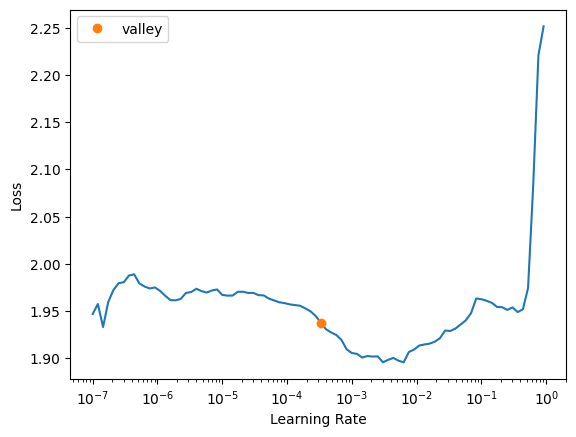

In [16]:
# Find the optimal learning rate
learn.lr_find()

# Fine-tune the model with the optimal learning rate
learn.fit_one_cycle(15, lr_max=1e-3)


In [17]:
# Validate on the test set and save the model
test_results = learn.validate()
print(f"Test Accuracy: {test_results[1]:.2f}%")
learn.export('/content/emotion_model.pkl')

Test Accuracy: 0.45%


In [18]:
class SimplifiedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [19]:
# Dataset path
path = "/content/fer2013_dataset"

# DataBlock with adjusted augmentation
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=[
        *aug_transforms(size=128, max_rotate=5, max_zoom=1.0, max_warp=0.1),
        Normalize.from_stats(*imagenet_stats)
    ]
)

# DataLoaders
dls = dblock.dataloaders(path, bs=32)

In [20]:
# Initialize model
num_classes = 7
model = SimplifiedCNN(num_classes)

In [21]:
# Create Learner
learn = Learner(dls, model, metrics=accuracy)

# Gradual unfreezing strategy
learn.freeze()
learn.fit_one_cycle(5, lr_max=1e-3)  # Train head

epoch,train_loss,valid_loss,accuracy,time
0,1.483195,1.430403,0.445451,01:35
1,1.326146,1.254235,0.510520,01:38
2,1.250942,1.174610,0.549115,01:43
3,1.119488,1.114712,0.570851,01:38
4,1.062626,1.102483,0.582137,01:37


In [ ]:
# Unfreeze and train whole model
learn.unfreeze()
learn.fit_one_cycle(15, lr_max=1e-4)  # Full fine-tuning

# Validate and save model
test_results = learn.validate()
print(f"Test Accuracy: {test_results[1]:.2f}%")
learn.export('/content/emotion_model2.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,1.034252,1.103236,0.582416,01:39
